In [1]:
# data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 处理数据集

In [2]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, IterableDataset
from torchvision import transforms
from transformers import BertTokenizer

EMOTION2ID = {"positive": 0, "neutral": 1, "negative": 2, "null": 3}
ID2EMOTION = {0: "positive", 1: "neutral", 2: "negative", 3: "null"}
SEED = 42

dataset_loc = "/content/drive/MyDrive/data/MultimodalSentimentAnalysis"


class MultimodalDataset(IterableDataset):
    def __init__(self, samples, tokenizer):
        self.data = samples
        self.tokenizer = tokenizer
        self.samples = []

        for guid, tag in zip(self.data["guid"], self.data["tag"]):
            # load img
            img = Image.open(f"{dataset_loc}/tidata/{guid}.jpg")
            transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ]
            )
            img = transform(img)

            # load txt
            with open(f"{dataset_loc}/tidata/{guid}.txt", "r", encoding="gb18030") as f:
                txt = f.read()
                txt = txt.replace("#", "")

            txt = self.tokenizer.encode(txt, add_special_tokens=True)
            self.samples.append((guid, txt, img, EMOTION2ID[tag]))

    def __len__(self):
        return len(self.data)

    def __iter__(self):
        for bundles in self.samples:
            yield bundles


class DataHandler:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.tokenizer = BertTokenizer.from_pretrained(
            "bert-base-uncased", mirror="bfsu"
        )
        self.get_dataloader()

    @staticmethod
    def _collate_fn(batch):
        guid = []
        txt = []
        img = []
        tag = []
        max_len = 0
        for sample in batch:
            guid.append(sample[0])
            txt.append(sample[1])
            max_len = max(max_len, len(sample[1]))
            img.append(np.array(sample[2]).tolist())
            tag.append(sample[3])

        padded_txt = []
        txt_mask = []
        for t in txt:
            padded = t + [0] * (max_len - len(t))
            mask = [1] * len(t) + [0] * (max_len - len(t))
            padded_txt.append(padded)
            txt_mask.append(mask)

        padded_txt = torch.LongTensor(padded_txt)
        txt_mask = torch.BoolTensor(txt_mask)
        img = torch.FloatTensor(img)
        tag = torch.LongTensor(tag)
        return guid, padded_txt, txt_mask, img, tag


    def get_dataloader(self):
        print("===== Data Info =====")
        samples = pd.read_csv(f"{dataset_loc}/label/train.txt")
        print(samples["tag"].value_counts())

        train_samples, val_samples = train_test_split(
            samples, test_size=0.2, random_state=SEED
        )
        test_samples = pd.read_csv(f"{dataset_loc}/label/test_without_label.txt").fillna(
            "null"
        )

        self.train_size = len(train_samples)
        self.val_size = len(val_samples)
        self.test_size = len(test_samples)

        print("\nTrain size:", self.train_size)
        print("Val size:", self.val_size)
        print("Test size:", self.test_size, "\n")
        print("Loading dataset...\n")

        train_data = MultimodalDataset(train_samples, self.tokenizer)
        val_data = MultimodalDataset(val_samples, self.tokenizer)
        test_data = MultimodalDataset(test_samples, self.tokenizer)

        self.train_loader = DataLoader(
            train_data, batch_size=self.batch_size, collate_fn=self._collate_fn
        )
        self.val_loader = DataLoader(
            val_data, batch_size=self.batch_size, collate_fn=self._collate_fn
        )
        self.test_loader = DataLoader(
            test_data, batch_size=self.batch_size, collate_fn=self._collate_fn
        )


## 2. 定义模型

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import ResNet18_Weights
from transformers import BertModel


class BertResnetWithConcat(nn.Module):
    def __init__(self):
        super().__init__()
        self.txt_model = BertModel.from_pretrained("bert-base-uncased")
        self.img_model = torchvision.models.resnet18(
            weights=ResNet18_Weights.IMAGENET1K_V1
        )

        self.fc = nn.Linear(768 + 1000, 3)
        self.only_img_fc = nn.Linear(1000, 3)
        self.only_txt_fc = nn.Linear(768, 3)

    def forward(self, txt, txt_mask, img, ablate):
        if ablate == 0:  # both
            img = self.img_model(img)
            txt = self.txt_model(input_ids=txt, attention_mask=txt_mask)  # type: ignore
            txt = txt.last_hidden_state[:, 0, :]  # CLS vector
            txt.view(txt.shape[0], -1)

            out = torch.cat((txt, img), dim=-1)
            out = self.fc(out)
        elif ablate == 1:  # img only
            img = self.img_model(img)
            out = self.only_img_fc(img)
        else:  # txt only
            txt = self.txt_model(input_ids=txt, attention_mask=txt_mask)  # type: ignore
            txt = txt.last_hidden_state[:, 0, :]  # CLS vector
            txt.view(txt.shape[0], -1)
            out = self.only_txt_fc(txt)

        return out


In [4]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import ResNet18_Weights
from transformers import BertModel


class BertResnetWithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.txt_model = BertModel.from_pretrained("bert-base-uncased")
        self.img_model = torchvision.models.resnet18(
            weights=ResNet18_Weights.IMAGENET1K_V1
        )

        self.txt_fc = nn.Linear(768, 256)
        self.img_fc = nn.Linear(1000, 256)

        self.fc = nn.Linear(512, 3)

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=512,
                nhead=4,
                dim_feedforward=512,
                dropout=0.4,
            ),
            num_layers=2,
        )

        self.activate = nn.LeakyReLU()

    def forward(self, txt, txt_mask, img, _):
        img = self.img_model(img)
        img = self.img_fc(img)
        img = self.activate(img)

        txt = self.txt_model(input_ids=txt, attention_mask=txt_mask)  # type: ignore
        txt = txt.last_hidden_state[:, 0, :]  # CLS vector
        txt.view(txt.shape[0], -1)
        txt = self.txt_fc(txt)
        txt = self.activate(txt)

        out = torch.cat((txt, img), dim=-1)
        out = self.transformer_encoder(out)
        out = self.fc(out)

        return out


In [5]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import DenseNet121_Weights
from transformers import BertModel


class BertDensenetWithConcat(nn.Module):
    def __init__(self):
        super().__init__()
        self.txt_model = BertModel.from_pretrained("bert-base-uncased")
        self.img_model = torchvision.models.densenet121(
            weights=DenseNet121_Weights.IMAGENET1K_V1
        )

        self.fc = nn.Linear(768 + 1000, 3)
        self.only_img_fc = nn.Linear(1000, 3)
        self.only_txt_fc = nn.Linear(768, 3)

    def forward(self, txt, txt_mask, img, ablate):
        if ablate == 0:  # both
            img = self.img_model(img)
            txt = self.txt_model(input_ids=txt, attention_mask=txt_mask)  # type: ignore
            txt = txt.last_hidden_state[:, 0, :]  # CLS vector
            txt.view(txt.shape[0], -1)

            out = torch.cat((txt, img), dim=-1)
            out = self.fc(out)
        elif ablate == 1:  # img only
            img = self.img_model(img)
            out = self.only_img_fc(img)
        else:  # txt only
            txt = self.txt_model(input_ids=txt, attention_mask=txt_mask)  # type: ignore
            txt = txt.last_hidden_state[:, 0, :]  # CLS vector
            txt.view(txt.shape[0], -1)
            out = self.only_txt_fc(txt)

        return out


In [6]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import DenseNet121_Weights
from transformers import BertModel


class BertDensenetWithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.txt_model = BertModel.from_pretrained("bert-base-uncased")
        self.img_model = torchvision.models.densenet121(
            weights=DenseNet121_Weights.IMAGENET1K_V1
        )

        self.txt_fc = nn.Linear(768, 256)
        self.img_fc = nn.Linear(1000, 256)

        self.fc = nn.Linear(512, 3)

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=512,
                nhead=4,
                dim_feedforward=512,
                dropout=0.4,
            ),
            num_layers=2,
        )

        self.activate = nn.LeakyReLU()

    def forward(self, txt, txt_mask, img, _):
        img = self.img_model(img)
        img = self.img_fc(img)
        img = self.activate(img)

        txt = self.txt_model(input_ids=txt, attention_mask=txt_mask)  # type: ignore
        txt = txt.last_hidden_state[:, 0, :]  # CLS vector
        txt.view(txt.shape[0], -1)
        txt = self.txt_fc(txt)
        txt = self.activate(txt)

        out = torch.cat((txt, img), dim=-1)
        out = self.transformer_encoder(out)
        out = self.fc(out)

        return out


## 3. 定义训练过程

In [7]:
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from torch import optim
from tqdm import tqdm

output_loc = "."

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


class Model:
    def __init__(
        self,
        max_epochs=10,
        lr=1e-5,
        batch_size=16,
        model=0,
        ablate=0,
    ):
        set_seed(SEED)

        self.epochs = max_epochs
        self.batch_size = batch_size
        self.ablate = ablate
        self.model_type = model
        if model == 0:
            self.model = BertResnetWithConcat().to(DEVICE)
        elif model == 1:
            self.model = BertResnetWithAttention().to(DEVICE)
        elif model == 2:
            self.model = BertDensenetWithConcat().to(DEVICE)
        elif model == 3:
            self.model = BertDensenetWithAttention().to(DEVICE)

        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
        self.data = DataHandler(self.batch_size)

    def train(self):
        self.train_loss = []
        self.val_accuracy = []
        print("===== Traning Info =====")
        print("Device:", DEVICE)
        print("Batch size:", self.batch_size)

        if self.ablate == 0:
            if self.model_type == 0:
                print("Model: BertResnetWithConcat")
            elif self.model_type == 1:
                print("Model: BertResnetWithCrossAttention")
            elif self.model_type == 2:
                print("Model: BertDensenetWithConcat")
            elif self.model_type == 3:
                print("Model: BertDensenetWithCrossAttention")
        elif self.ablate == 1:
            if self.model_type == 0:
                print("Model: Resnet Only")
            elif self.model_type == 2:
                print("Model: Densenet Only")
        elif self.ablate == 2:
            print("Model: Bert only")

        print("\n==== Starting Train ====")

        best_metrics = [float("inf"), 0, 0, 0, 0]
        early_stop_patience = 2
        early_stop_count = 0
        epoch = 0

        for epoch in range(1, self.epochs + 1):
            self._epoch_train(epoch)
            metrics = self._evaluate()
            if metrics[1] > best_metrics[1]:
                best_metrics = metrics
                torch.save(self.model.state_dict(), f"{output_loc}/model.pt")
                early_stop_count = 0
            else:
                early_stop_count += 1
                if early_stop_count == early_stop_patience:
                    print("Early stop...")
                    break

        print(f"The training epoch is {epoch}")
        print(f"Choose model with best accuracy: {best_metrics[1]}, with:")
        print(f"Precision: {best_metrics[2]}")
        print(f"Recall: {best_metrics[3]}")
        print(f"F1: {best_metrics[4]}")
        self.model.load_state_dict(torch.load(f"{output_loc}/model.pt"))

        def moving_average(data, window_size):
            weights = np.repeat(1.0, window_size) / window_size
            smoothed_data = np.convolve(data, weights, "valid")
            return smoothed_data

        window_size = 15
        self.train_loss = moving_average(self.train_loss, window_size)

    def _epoch_train(self, epoch):
        self.model.train()
        epoch_loss = 0
        correct = 0
        for _, txt, txt_mask, image, label in tqdm(self.data.train_loader):
            txt = txt.to(DEVICE)
            txt_mask = txt_mask.to(DEVICE)
            image = image.to(DEVICE)
            label = label.to(DEVICE)

            self.optimizer.zero_grad()
            output = self.model(txt, txt_mask, image, self.ablate)

            loss = self.criterion(output, label)
            loss.backward()

            # used to prevent gradient explosion
            # clip_grad_norm_(self.model.parameters(), 1)

            self.optimizer.step()

            pred = output.argmax(dim=1)
            correct += (pred == label).sum().item()

            self.train_loss.append(loss.item())
            epoch_loss += loss.item()

        epoch_loss /= len(self.data.train_loader)
        epoch_acc = correct / self.data.train_size
        print(f"Train Epoch {epoch}")
        print("Train set: \nLoss: {}, Accuracy: {}".format(epoch_loss, epoch_acc))

    def _evaluate(self):
        self.model.eval()
        epoch_loss = 0
        preds = []
        labels = []

        with torch.no_grad():
            for _, txt, txt_mask, image, label in self.data.val_loader:
                txt = txt.to(DEVICE)
                txt_mask = txt_mask.to(DEVICE)
                image = image.to(DEVICE)
                label = label.to(DEVICE)

                self.optimizer.zero_grad()
                output = self.model(txt, txt_mask, image, self.ablate)

                loss = self.criterion(output, label)

                pred = output.argmax(dim=1)
                epoch_loss += loss.item()

                preds.append(pred)
                labels.append(label)

        epoch_loss /= len(self.data.val_loader)

        preds = torch.cat(preds).cpu().numpy()
        labels = torch.cat(labels).cpu().numpy()

        epoch_acc = accuracy_score(labels, preds)
        self.val_accuracy.append(epoch_acc)

        f1 = f1_score(labels, preds, average="macro")
        precision = precision_score(labels, preds, average="macro")
        recall = recall_score(labels, preds, average="macro")
        print(
            "Valid set: \nLoss: {}, Accuracy: {}, Precision: {}, Recall: {}, F1: {}".format(
                epoch_loss, epoch_acc, precision, recall, f1
            )
        )
        return epoch_loss, epoch_acc, precision, recall, f1

    def save_test_result(self):
        print(f"Predict and save test result...")
        self.model.eval()
        guid_list = []
        tag_list = []

        with torch.no_grad():
            for guid, txt, txt_mask, image, _ in tqdm(self.data.test_loader):
                txt = txt.to(DEVICE)
                txt_mask = txt_mask.to(DEVICE)
                image = image.to(DEVICE)

                self.optimizer.zero_grad()
                output = self.model(txt, txt_mask, image, self.ablate)
                pred = output.argmax(dim=1)

                guid_list.extend(guid)
                emotion = [ID2EMOTION[p.item()] for p in pred]
                tag_list.extend(emotion)

        df = pd.DataFrame({"guid": guid_list, "tag": tag_list})
        df.to_csv(f"{output_loc}/test_with_predict.txt", index=False)
        print("Save successfully!")

## 4. 开始训练

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: BertResnetWithConcat

==== Starting Train ====


100%|██████████| 200/200 [01:44<00:00,  1.92it/s]


Train Epoch 1
Train set: 
Loss: 0.8496885965764522, Accuracy: 0.6215625
Valid set: 
Loss: 0.7498187690973281, Accuracy: 0.67625, Precision: 0.5868308612211051, Recall: 0.5484813384237167, F1: 0.5478206304758767


100%|██████████| 200/200 [01:39<00:00,  2.02it/s]


Train Epoch 2
Train set: 
Loss: 0.4730966706573963, Accuracy: 0.813125
Valid set: 
Loss: 0.7430943235754967, Accuracy: 0.68875, Precision: 0.5920880425560875, Recall: 0.5554251832407935, F1: 0.5605968505617628


100%|██████████| 200/200 [01:39<00:00,  2.00it/s]


Train Epoch 3
Train set: 
Loss: 0.28620767038315537, Accuracy: 0.91
Valid set: 
Loss: 0.8057941061258316, Accuracy: 0.6875, Precision: 0.5931140016401047, Recall: 0.5654472218118106, F1: 0.5697576865997919


100%|██████████| 200/200 [01:39<00:00,  2.01it/s]


Train Epoch 4
Train set: 
Loss: 0.1588735567033291, Accuracy: 0.9565625
Valid set: 
Loss: 0.8780804842710495, Accuracy: 0.6925, Precision: 0.59283060033616, Recall: 0.5667815392802297, F1: 0.5752784441376425


100%|██████████| 200/200 [01:40<00:00,  1.99it/s]


Train Epoch 5
Train set: 
Loss: 0.08240970600396395, Accuracy: 0.9840625
Valid set: 
Loss: 0.9756992894411087, Accuracy: 0.70375, Precision: 0.6198390440804983, Recall: 0.5627540687781653, F1: 0.5821047034625925


100%|██████████| 200/200 [01:39<00:00,  2.00it/s]


Train Epoch 6
Train set: 
Loss: 0.05104452925734222, Accuracy: 0.991875
Valid set: 
Loss: 0.9996108424663543, Accuracy: 0.67625, Precision: 0.5671192380900464, Recall: 0.5651960712201676, F1: 0.564841797940677


100%|██████████| 200/200 [01:40<00:00,  2.00it/s]


Train Epoch 7
Train set: 
Loss: 0.03359711333177984, Accuracy: 0.995625
Valid set: 
Loss: 1.0611850214004517, Accuracy: 0.68, Precision: 0.5779331650483052, Recall: 0.5961195741185265, F1: 0.5851113595559267
Early stop...
The training epoch is 7
Choose model with best accuracy: 0.70375, with:
Precision: 0.6198390440804983
Recall: 0.5627540687781653
F1: 0.5821047034625925
Training time: 821.5144982337952


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: BertResnetWithCrossAttention

==== Starting Train ====


100%|██████████| 200/200 [01:40<00:00,  1.99it/s]


Train Epoch 1
Train set: 
Loss: 0.8238494530320167, Accuracy: 0.639375
Valid set: 
Loss: 0.7144250118732453, Accuracy: 0.6875, Precision: 0.6310528989116445, Recall: 0.5244132019930867, F1: 0.5186616560683862


100%|██████████| 200/200 [01:41<00:00,  1.98it/s]


Train Epoch 2
Train set: 
Loss: 0.5309519196301699, Accuracy: 0.788125
Valid set: 
Loss: 0.7280535227060319, Accuracy: 0.69875, Precision: 0.6262396322783377, Recall: 0.5554171882092259, F1: 0.565406518124089


100%|██████████| 200/200 [01:40<00:00,  1.98it/s]


Train Epoch 3
Train set: 
Loss: 0.3378062539175153, Accuracy: 0.88
Valid set: 
Loss: 0.81383544921875, Accuracy: 0.69125, Precision: 0.6065286096371701, Recall: 0.5808213477150094, F1: 0.5856840160180931


100%|██████████| 200/200 [01:42<00:00,  1.96it/s]


Train Epoch 4
Train set: 
Loss: 0.19242971505969764, Accuracy: 0.9409375
Valid set: 
Loss: 0.9050842416286469, Accuracy: 0.68125, Precision: 0.5882548701298701, Recall: 0.5915840460104472, F1: 0.5880629953356588
Early stop...
The training epoch is 4
Choose model with best accuracy: 0.69875, with:
Precision: 0.6262396322783377
Recall: 0.5554171882092259
F1: 0.565406518124089
Training time: 473.31308245658875


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 124MB/s]


===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: BertDensenetWithConcat

==== Starting Train ====


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Train Epoch 1
Train set: 
Loss: 0.8697494693100453, Accuracy: 0.6146875
Valid set: 
Loss: 0.7131051075458527, Accuracy: 0.705, Precision: 0.6215363600572312, Recall: 0.5672493019271437, F1: 0.5640990201954953


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Train Epoch 2
Train set: 
Loss: 0.5022301672399044, Accuracy: 0.8046875
Valid set: 
Loss: 0.7050493305921555, Accuracy: 0.69125, Precision: 0.5992486440762302, Recall: 0.5644525332843825, F1: 0.557953012514859


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Train Epoch 3
Train set: 
Loss: 0.31133358407765627, Accuracy: 0.8921875
Valid set: 
Loss: 0.7373381960391998, Accuracy: 0.7125, Precision: 0.6034112087065244, Recall: 0.5766582814775586, F1: 0.5828856829964085


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Train Epoch 4
Train set: 
Loss: 0.18186696708202363, Accuracy: 0.9509375
Valid set: 
Loss: 0.7859849151968956, Accuracy: 0.71875, Precision: 0.615297043575732, Recall: 0.5830889518684176, F1: 0.5929293428863149


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Train Epoch 5
Train set: 
Loss: 0.09447857830673456, Accuracy: 0.9815625
Valid set: 
Loss: 0.9386572168767452, Accuracy: 0.7075, Precision: 0.6111614378081445, Recall: 0.5401167231968699, F1: 0.5599319857050818


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


Train Epoch 6
Train set: 
Loss: 0.05526713373605162, Accuracy: 0.993125
Valid set: 
Loss: 0.9600751166045666, Accuracy: 0.71, Precision: 0.6146588164251208, Recall: 0.5713878500677873, F1: 0.586913610646857
Early stop...
The training epoch is 6
Choose model with best accuracy: 0.71875, with:
Precision: 0.615297043575732
Recall: 0.5830889518684176
F1: 0.5929293428863149
Training time: 828.187252998352


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: BertDensenetWithCrossAttention

==== Starting Train ====


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Train Epoch 1
Train set: 
Loss: 0.8073148091137409, Accuracy: 0.6359375
Valid set: 
Loss: 0.7008783906698227, Accuracy: 0.71, Precision: 0.6572816618271163, Recall: 0.5567486274662806, F1: 0.5576215136129004


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


Train Epoch 2
Train set: 
Loss: 0.5329073137789965, Accuracy: 0.7840625
Valid set: 
Loss: 0.7102836936712265, Accuracy: 0.715, Precision: 0.6477948192697254, Recall: 0.5764847359923316, F1: 0.5795817342968533


100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


Train Epoch 3
Train set: 
Loss: 0.339580100774765, Accuracy: 0.8784375
Valid set: 
Loss: 0.8083603012561799, Accuracy: 0.70375, Precision: 0.6271379662785628, Recall: 0.5828429180969779, F1: 0.5849830265714345


100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


Train Epoch 4
Train set: 
Loss: 0.19785760063678026, Accuracy: 0.938125
Valid set: 
Loss: 0.8779475706815719, Accuracy: 0.70375, Precision: 0.603378756119883, Recall: 0.5874192741662622, F1: 0.5939001349527665
Early stop...
The training epoch is 4
Choose model with best accuracy: 0.715, with:
Precision: 0.6477948192697254
Recall: 0.5764847359923316
F1: 0.5795817342968533
Training time: 558.1435964107513
===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: Resnet Only

==== Starting Train ====


100%|██████████| 200/200 [01:08<00:00,  2.92it/s]


Train Epoch 1
Train set: 
Loss: 0.9367922446131707, Accuracy: 0.5796875
Valid set: 
Loss: 0.895334648489952, Accuracy: 0.57125, Precision: 0.46997248191278046, Recall: 0.41962232323678106, F1: 0.43059609458325604


100%|██████████| 200/200 [01:11<00:00,  2.79it/s]


Train Epoch 2
Train set: 
Loss: 0.6585938584804535, Accuracy: 0.7140625
Valid set: 
Loss: 0.8759930753707885, Accuracy: 0.5825, Precision: 0.4760442487173153, Recall: 0.434645946956057, F1: 0.44475511594604583


100%|██████████| 200/200 [01:12<00:00,  2.75it/s]


Train Epoch 3
Train set: 
Loss: 0.49178438156843185, Accuracy: 0.8203125
Valid set: 
Loss: 0.889471036195755, Accuracy: 0.59625, Precision: 0.49707896575821103, Recall: 0.4562329585902137, F1: 0.4675277022347822


100%|██████████| 200/200 [01:12<00:00,  2.77it/s]


Train Epoch 4
Train set: 
Loss: 0.34435295216739176, Accuracy: 0.91375
Valid set: 
Loss: 0.9257272279262543, Accuracy: 0.59375, Precision: 0.5019576102887954, Recall: 0.465564866036317, F1: 0.4773254051292504


100%|██████████| 200/200 [01:12<00:00,  2.76it/s]


Train Epoch 5
Train set: 
Loss: 0.21913708034902812, Accuracy: 0.970625
Valid set: 
Loss: 0.9811245912313461, Accuracy: 0.59625, Precision: 0.4969459035486559, Recall: 0.4676794985857322, F1: 0.47772231980616375
Early stop...
The training epoch is 5
Choose model with best accuracy: 0.59625, with:
Precision: 0.49707896575821103
Recall: 0.4562329585902137
F1: 0.4675277022347822
Training time: 434.4589614868164
===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: Bert only

==== Starting Train ====


100%|██████████| 200/200 [01:29<00:00,  2.23it/s]


Train Epoch 1
Train set: 
Loss: 0.8058575423061848, Accuracy: 0.64875
Valid set: 
Loss: 0.7062317603826522, Accuracy: 0.69375, Precision: 0.6439365767999173, Recall: 0.5573662703049816, F1: 0.5577014657642584


100%|██████████| 200/200 [01:29<00:00,  2.22it/s]


Train Epoch 2
Train set: 
Loss: 0.6176616565138101, Accuracy: 0.7509375
Valid set: 
Loss: 0.7043585062026978, Accuracy: 0.7025, Precision: 0.674945994371439, Recall: 0.5614628178797901, F1: 0.5648301128077976


100%|██████████| 200/200 [01:28<00:00,  2.26it/s]


Train Epoch 3
Train set: 
Loss: 0.463510375469923, Accuracy: 0.8259375
Valid set: 
Loss: 0.7930830830335617, Accuracy: 0.7025, Precision: 0.6000514914119681, Recall: 0.562974092046905, F1: 0.5652737304734151


100%|██████████| 200/200 [01:26<00:00,  2.30it/s]


Train Epoch 4
Train set: 
Loss: 0.3203350776806474, Accuracy: 0.8796875
Valid set: 
Loss: 0.893528220653534, Accuracy: 0.68, Precision: 0.577010410726342, Recall: 0.5672664645949088, F1: 0.5705483448867509
Early stop...
The training epoch is 4
Choose model with best accuracy: 0.7025, with:
Precision: 0.674945994371439
Recall: 0.5614628178797901
F1: 0.5648301128077976
Training time: 422.9268465042114
===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: Densenet Only

==== Starting Train ====


100%|██████████| 200/200 [01:23<00:00,  2.38it/s]


Train Epoch 1
Train set: 
Loss: 0.9691132307052612, Accuracy: 0.5596875
Valid set: 
Loss: 0.891026707291603, Accuracy: 0.60375, Precision: 0.4647574900699045, Recall: 0.42568820698731646, F1: 0.43002602472348733


100%|██████████| 200/200 [01:23<00:00,  2.38it/s]


Train Epoch 2
Train set: 
Loss: 0.6781162221729755, Accuracy: 0.7171875
Valid set: 
Loss: 0.8678197860717773, Accuracy: 0.62125, Precision: 0.48943872965145313, Recall: 0.45228309319456517, F1: 0.45912960882760734


100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train Epoch 3
Train set: 
Loss: 0.5174325609207153, Accuracy: 0.8171875
Valid set: 
Loss: 0.8685394263267517, Accuracy: 0.63, Precision: 0.5074113894279988, Recall: 0.4714980322628306, F1: 0.48046993021950607


100%|██████████| 200/200 [01:24<00:00,  2.35it/s]


Train Epoch 4
Train set: 
Loss: 0.38553887240588663, Accuracy: 0.8915625
Valid set: 
Loss: 0.8820705312490463, Accuracy: 0.625, Precision: 0.5002712306194722, Recall: 0.4746550037278167, F1: 0.4825371093319217


100%|██████████| 200/200 [01:24<00:00,  2.36it/s]


Train Epoch 5
Train set: 
Loss: 0.2744830487668514, Accuracy: 0.9525
Valid set: 
Loss: 0.9070168447494507, Accuracy: 0.625, Precision: 0.5034696467718275, Recall: 0.4772465665603434, F1: 0.4855883613198615
Early stop...
The training epoch is 5
Choose model with best accuracy: 0.63, with:
Precision: 0.5074113894279988
Recall: 0.4714980322628306
F1: 0.48046993021950607
Training time: 506.47434544563293


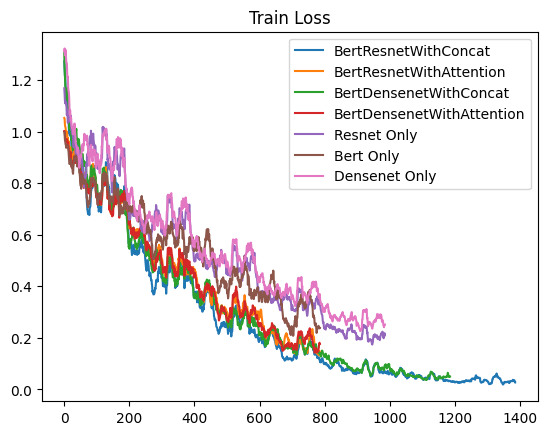

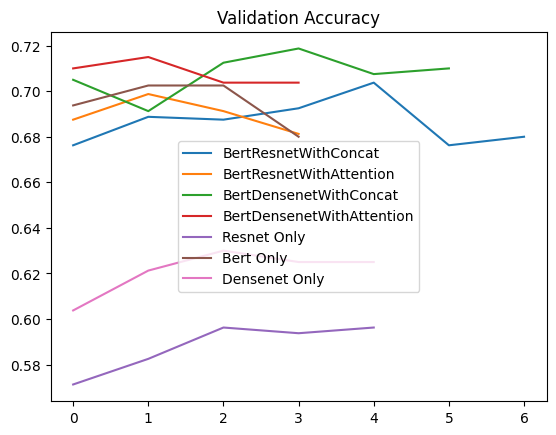

In [8]:
import time

from matplotlib import pyplot as plt

if __name__ == "__main__":
    bert_resnet_with_concat = Model(model=0)

    start_time = time.time()
    bert_resnet_with_concat.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)

    bert_resnet_with_attention = Model(model=1)

    start_time = time.time()
    bert_resnet_with_attention.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)

    bert_densenet_with_concat = Model(model=2)

    start_time = time.time()
    bert_densenet_with_concat.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)

    bert_densenet_with_attention = Model(model=3)

    start_time = time.time()
    bert_densenet_with_attention.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)

    resnet = Model(model=0, ablate=1)

    start_time = time.time()
    resnet.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)

    bert = Model(model=0, ablate=2)

    start_time = time.time()
    bert.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)

    densenet = Model(model=2, ablate=1)

    start_time = time.time()
    densenet.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)

    plt.plot(bert_resnet_with_concat.train_loss, label="BertResnetWithConcat")
    plt.plot(bert_resnet_with_attention.train_loss, label="BertResnetWithAttention")
    plt.plot(bert_densenet_with_concat.train_loss, label="BertDensenetWithConcat")
    plt.plot(bert_densenet_with_attention.train_loss, label="BertDensenetWithAttention")
    plt.plot(resnet.train_loss, label="Resnet Only")
    plt.plot(bert.train_loss, label="Bert Only")
    plt.plot(densenet.train_loss, label="Densenet Only")
    plt.title("Train Loss")
    plt.legend()
    plt.show()

    plt.plot(bert_resnet_with_concat.val_accuracy, label="BertResnetWithConcat")
    plt.plot(bert_resnet_with_attention.val_accuracy, label="BertResnetWithAttention")
    plt.plot(bert_densenet_with_concat.val_accuracy, label="BertDensenetWithConcat")
    plt.plot(
        bert_densenet_with_attention.val_accuracy, label="BertDensenetWithAttention"
    )
    plt.plot(resnet.val_accuracy, label="Resnet Only")
    plt.plot(bert.val_accuracy, label="Bert Only")
    plt.plot(densenet.val_accuracy, label="Densenet Only")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.show()

In [9]:
import time

if __name__ == "__main__":
    model = Model(model=3)

    start_time = time.time()
    model.train()
    end_time = time.time()

    print("Training time:", end_time - start_time)
    model.save_test_result()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


===== Data Info =====
tag
positive    2388
negative    1193
neutral      419
Name: count, dtype: int64

Train size: 3200
Val size: 800
Test size: 511 

Loading dataset...

===== Traning Info =====
Device: cuda
Batch size: 16
Model: BertDensenetWithCrossAttention

==== Starting Train ====


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Train Epoch 1
Train set: 
Loss: 0.8073154719173908, Accuracy: 0.6359375
Valid set: 
Loss: 0.7008728605508804, Accuracy: 0.71, Precision: 0.6572816618271163, Recall: 0.5567486274662806, F1: 0.5576215136129004


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Train Epoch 2
Train set: 
Loss: 0.5327374066412449, Accuracy: 0.7846875
Valid set: 
Loss: 0.7117498993873597, Accuracy: 0.715, Precision: 0.6480306125663712, Recall: 0.5772191062919193, F1: 0.5797513004264059


100%|██████████| 200/200 [02:02<00:00,  1.64it/s]


Train Epoch 3
Train set: 
Loss: 0.33996938541531563, Accuracy: 0.8784375
Valid set: 
Loss: 0.8082500898838043, Accuracy: 0.7025, Precision: 0.6306510453151383, Recall: 0.5888046532362928, F1: 0.5915798686052978


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Train Epoch 4
Train set: 
Loss: 0.19753863405436278, Accuracy: 0.9378125
Valid set: 
Loss: 0.8785968056321144, Accuracy: 0.70625, Precision: 0.6102511127498481, Recall: 0.592125469548204, F1: 0.5996495983957516
Early stop...
The training epoch is 4
Choose model with best accuracy: 0.715, with:
Precision: 0.6480306125663712
Recall: 0.5772191062919193
F1: 0.5797513004264059
Training time: 563.9655928611755
Predict and save test result...


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]

Save successfully!
